# The Comparative Study of Neural Networks and Tsetlin Machines: An Analysis of Performance, Explainability, and Energy Efficiency

### Importing dependencies

In [1]:
import time
import psutil
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_kddcup99, load_wine, load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from tmu.models.classification.vanilla_classifier import TMClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from scipy.sparse import csr_matrix
from tmu.data import MNIST


2024-08-22 21:41:52,627 - tmu.util.cuda_profiler - WARNING - Could not import pycuda: No module named 'pycuda'
2024-08-22 21:41:52,628 - tmu.clause_bank.clause_bank_cuda - ERROR - No module named 'pycuda'
Traceback (most recent call last):
  File "D:\FinalProject\venv\Lib\site-packages\tmu\clause_bank\clause_bank_cuda.py", line 41, in <module>
    from pycuda._driver import Device, Context
ModuleNotFoundError: No module named 'pycuda'
2024-08-22 21:41:52,629 - tmu.clause_bank.clause_bank_cuda - WARNING - Could not import pycuda. This indicates that it is not installed! A possible fix is to run 'pip install pycuda'. Fallback to CPU ClauseBanks.


### Memory detection function

In [2]:
def measure_memory():
    process = psutil.Process()
    memory_usage = process.memory_info().rss / (1024 * 1024)
    return memory_usage

### Data preprocessing

In [3]:
def preprocess_iris():
    iris = load_iris()
    X = iris.data
    y = iris.target

    y = y.reshape(-1, 1)
    encoder = OneHotEncoder(sparse_output=False)
    y = encoder.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test, X_train.shape[1], y_train.shape[1]

In [4]:
def preprocess_wine():
    wine = load_wine()
    X, y = wine.data, wine.target

    scaler = StandardScaler() #Standardization adjusts the data so that it has a mean of 0 and a standard deviation of 1.
    X_scaled = scaler.fit_transform(X)
    
    encoder = OneHotEncoder(sparse_output=False)  
    y_onehot = encoder.fit_transform(y.reshape(-1, 1))

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_onehot, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test, X_train.shape[1], y_train.shape[1]

In [5]:
def preprocess_imdb():
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=5000)

    X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=256)
    X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=256)
    
    y_train = tf.keras.utils.to_categorical(y_train, 2)
    y_test = tf.keras.utils.to_categorical(y_test, 2)
    
    return X_train, X_test, y_train, y_test, X_train.shape[1], y_train.shape[1]

In [6]:
def preprocess_mnist():
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
    X_train = X_train.reshape(-1, 28 * 28) / 255.0
    X_test = X_test.reshape(-1, 28 * 28) / 255.0

    y_train = tf.keras.utils.to_categorical(y_train, 10)
    y_test = tf.keras.utils.to_categorical(y_test, 10)

    return X_train, X_test, y_train, y_test, X_train.shape[1], y_train.shape[1]

### Model Architecture Function Creation

In [7]:
def train_nn_iris(X_train, y_train, X_test, y_test, input_shape, epochs=20, target_accuracy=90):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(input_shape,)),
        tf.keras.layers.Dense(500, activation='relu'),
        tf.keras.layers.Dense(500, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(3, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    start_time = time.time()
    memory_before = measure_memory()
    epochs_used = 0

    for epoch in range(epochs):
        model.fit(X_train, y_train, epochs=1, validation_split=0.2, verbose=2)
        test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
        print(f"Epoch {epoch + 1}: Test Accuracy = {test_accuracy * 100:.2f}%")
        epochs_used = epoch + 1

        if test_accuracy * 100 >= target_accuracy:
            print(f"Target accuracy of {target_accuracy}% reached. Stopping training.")
            break

    memory_after = measure_memory()
    train_time = time.time() - start_time
    memory_used = memory_after - memory_before

    final_train_accuracy = model.evaluate(X_train, y_train, verbose=0)[1] * 100

    return final_train_accuracy, test_accuracy * 100, train_time, memory_used, epochs_used

In [8]:
def train_nn_wine(X_train, y_train, X_test, y_test, input_shape, num_classes, epochs=50, target_accuracy=90):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(y_train.shape[1], activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    start_time = time.time()
    memory_before = measure_memory()
    epochs_used = 0

    for epoch in range(epochs):
        model.fit(X_train, y_train, batch_size=32, epochs=1, validation_split=0.2, verbose=2)
        test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
        print(f"Epoch {epoch + 1}: Test Accuracy = {test_accuracy * 100:.2f}%")
        epochs_used = epoch + 1

        if test_accuracy * 100 >= target_accuracy:
            print(f"Target accuracy of {target_accuracy}% reached. Stopping training.")
            break

    memory_after = measure_memory()
    train_time = time.time() - start_time
    memory_used = memory_after - memory_before

    final_train_accuracy = model.evaluate(X_train, y_train, verbose=0)[1] * 100

    return final_train_accuracy, test_accuracy * 100, train_time, memory_used, epochs_used

In [9]:
def train_nn_IMDB(X_train, y_train, X_test, y_test, input_shape, num_classes, epochs=50, target_accuracy=90):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=5000, output_dim=128),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    start_time = time.time()
    memory_before = measure_memory()
    epochs_used = 0

    for epoch in range(epochs):
        model.fit(X_train, y_train, batch_size=64, epochs=1, validation_split=0.2, verbose=2)
        test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
        print(f"Epoch {epoch + 1}: Test Accuracy = {test_accuracy * 100:.2f}%")
        epochs_used = epoch + 1

        if test_accuracy * 100 >= target_accuracy:
            print(f"Target accuracy of {target_accuracy}% reached. Stopping training.")
            break

    memory_after = measure_memory()
    train_time = time.time() - start_time
    memory_used = memory_after - memory_before

    final_train_accuracy = model.evaluate(X_train, y_train, verbose=0)[1] * 100

    return final_train_accuracy, test_accuracy * 100, train_time, memory_used, epochs_used

In [10]:
def train_nn(X_train, y_train, X_test, y_test, input_shape, num_classes, epochs=20, target_accuracy=90):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(input_shape,)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    start_time = time.time()
    memory_before = measure_memory()
    epochs_used = 0

    for epoch in range(epochs):
        model.fit(X_train, y_train, batch_size=128, epochs=1, validation_split=0.2, verbose=2)
        test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
        print(f"Epoch {epoch + 1}: Test Accuracy = {test_accuracy * 100:.2f}%")
        epochs_used = epoch + 1

        if test_accuracy * 100 >= target_accuracy:
            print(f"Target accuracy of {target_accuracy}% reached. Stopping training.")
            break

    memory_after = measure_memory()
    train_time = time.time() - start_time
    memory_used = memory_after - memory_before

    final_train_accuracy = model.evaluate(X_train, y_train, verbose=0)[1] * 100

    return final_train_accuracy, test_accuracy * 100, train_time, memory_used, epochs_used

In [11]:
def train_tm(X_train, y_train, X_test, y_test, num_clauses, T, s, epochs=10,target_accuracy=90,max_included_literals=100):
    if isinstance(X_train, csr_matrix):
        X_train = X_train.toarray()
    if isinstance(X_test, csr_matrix):
        X_test = X_test.toarray()

    tm = TMClassifier(
        type_iii_feedback=False,
        number_of_clauses=num_clauses,
        T=T,
        s=s,
        max_included_literals=max_included_literals,
        platform="CPU",
        weighted_clauses=True,
        seed=42
    )

    start_time = time.time()
    memory_before = measure_memory()
    epochs_used = 0

    for epoch in range(epochs):
        tm.fit(X_train, y_train)
        test_accuracy = 100 * (tm.predict(X_test) == y_test).mean()
        print(f"Epoch {epoch + 1}: Test Accuracy = {test_accuracy:.2f}%")
        epochs_used = epoch + 1

        if test_accuracy >= target_accuracy:
            print(f"Target accuracy of {target_accuracy}% reached. Stopping training.")
            break

    
    train_time = time.time() - start_time

    train_accuracy = 100 * (tm.predict(X_train) == y_train).mean()
    memory_after = measure_memory()
    memory_used = memory_after - memory_before

    return train_accuracy, test_accuracy, train_time, memory_used, epochs_used

In [12]:
def train_tm_IMDB():
    
    (train_x, train_y), (test_x, test_y) = tf.keras.datasets.imdb.load_data(num_words=2000, index_from=2)

    # Processing the Vocabulary
    word_to_id = tf.keras.datasets.imdb.get_word_index()
    word_to_id = {k: (v + 2) for k, v in word_to_id.items()}
    word_to_id["<PAD>"] = 0
    word_to_id["<START>"] = 1
    word_to_id["<UNK>"] = 2
    id_to_word = {value: key for key, value in word_to_id.items()}

    # Decoding Reviews into Text
    def decode_reviews(data):
        documents = []
        for sequence in data:
            documents.append([id_to_word.get(word_id, "<UNK>") for word_id in sequence])
        return documents

    training_documents = decode_reviews(train_x)
    testing_documents = decode_reviews(test_x)

    # Bag-of-Words Representation
    vectorizer_X = CountVectorizer(tokenizer=lambda s: s, token_pattern=None, ngram_range=(1, 2), lowercase=False, binary=True)
    X_train = vectorizer_X.fit_transform(training_documents)
    X_test = vectorizer_X.transform(testing_documents)
    Y_train = train_y.astype(np.uint32)
    Y_test = test_y.astype(np.uint32)

    # Feature SelectionReduces the feature space to the most relevant words or bigrams, 
    # which can improve classifier performance and reduce computational load.
    SKB = SelectKBest(chi2, k=2000)
    X_train = SKB.fit_transform(X_train, Y_train).toarray().astype(np.uint32)
    X_test = SKB.transform(X_test).toarray().astype(np.uint32)

    tm = TMClassifier(200, T=4000, s=2.0, platform="CPU", weighted_clauses=True, clause_drop_p=0.75)

    train_accuracies = []
    test_accuracies = []
    epoch_times = []
    memory_before = measure_memory()
    epochs_used = 0
    epochs = 20

    for epoch in range(epochs):
        start_time = time.time()

        tm.fit(X_train, Y_train)

        end_time = time.time()
        epoch_time = end_time - start_time

        train_accuracy = 100 * (tm.predict(X_train) == Y_train).mean()
        test_accuracy = 100 * (tm.predict(X_test) == Y_test).mean()

        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        epoch_times.append(epoch_time)

        print(f"Epoch: {epoch + 1}, Training Accuracy: {train_accuracy:.2f}%, "
              f"Test Accuracy: {test_accuracy:.2f}%, Training Time: {epoch_time:.2f} seconds")

        epochs_used = epoch + 1
        if test_accuracy >= 87:
            print(f"Target accuracy of {87}% reached. Stopping training.")
            break
            
    memory_after = measure_memory()
    memory_used = memory_after - memory_before

    return train_accuracies[-1], test_accuracies[-1], sum(epoch_times), memory_used, epochs_used

In [13]:
def train_tm_mnist():

    data = MNIST().get()

    tm = TMClassifier(
        type_iii_feedback=False, number_of_clauses=200, T=1000, s=5, max_included_literals=32,
        platform="CPU", weighted_clauses=True, seed=42,
    )

    train_accuracies = []
    test_accuracies = []
    epoch_times = []
    memory_before = measure_memory()
    epochs_used = 0

    for epoch in range(20):
        start_time = time.time() 

        tm.fit(data["x_train"].astype(np.uint32), data["y_train"].astype(np.uint32))

        end_time = time.time() 
        epoch_time = end_time - start_time

        train_accuracy = 100 * (tm.predict(data["x_train"]) == data["y_train"]).mean()
        test_accuracy = 100 * (tm.predict(data["x_test"]) == data["y_test"]).mean()

        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        epoch_times.append(epoch_time)

        print(f"Epoch: {epoch + 1}, Training Accuracy: {train_accuracy:.2f}%, "
              f"Test Accuracy: {test_accuracy:.2f}%, Training Time: {epoch_time:.2f} seconds")
        epochs_used = epoch + 1
        if test_accuracy >= 95:
            print(f"Target accuracy of {95}% reached. Stopping training.")
            break
    memory_after = measure_memory()
    memory_used = memory_after - memory_before

    return train_accuracies[-1], test_accuracies[-1], sum(epoch_times), memory_used, epochs_used

### Define the dataset and target accuracy

In [14]:
    datasets = {
        "Iris": (preprocess_iris(), 90),
        "Wine": (preprocess_wine(), 80),
        "IMDB": (preprocess_imdb(), 87),
        "MNIST": (preprocess_mnist(), 95)
    }

    results = {}

### Dataset training and evaluation

In [15]:
name = "Iris"
data, target_accuracy = datasets[name]
X_train, X_test, y_train, y_test, input_shape, num_classes = data

print(f"\nTraining on {name} dataset with Neural Network:")
nn_results = train_nn_iris(X_train, y_train, X_test, y_test, input_shape, epochs=50, target_accuracy=target_accuracy)

print(f"\nTraining on {name} dataset with Tsetlin Machine:")
tm_results = train_tm(X_train.astype(np.uint32), y_train.argmax(axis=1).astype(np.uint32),
                      X_test.astype(np.uint32), y_test.argmax(axis=1).astype(np.uint32),
                      num_clauses=500, T=1000, s=1, epochs=50, target_accuracy=target_accuracy)

results[name] = {
    "Neural Network": nn_results,
    "Tsetlin Machine": tm_results
}

print(f"\nResults for {name} dataset:")
print("Neural Network Results:")
print(f"Test Accuracy: {nn_results[1]:.2f}%")
print(f"Training Time: {nn_results[2]:.2f} seconds")
print(f"Memory Used: {nn_results[3]:.2f} MB")
print(f"Epochs Used: {nn_results[4]}")  

print("Tsetlin Machine Results:")
print(f"Test Accuracy: {tm_results[1]:.2f}%")
print(f"Training Time: {tm_results[2]:.2f} seconds")
print(f"Memory Used: {tm_results[3]:.2f} MB")
print(f"Epochs Used: {tm_results[4]}") 



Training on Iris dataset with Neural Network:
3/3 - 1s - 171ms/step - accuracy: 0.3229 - loss: 1.1162 - val_accuracy: 0.5000 - val_loss: 0.8713
1/1 - 0s - 12ms/step - accuracy: 0.6333 - loss: 0.8327
Epoch 1: Test Accuracy = 63.33%
3/3 - 0s - 15ms/step - accuracy: 0.6250 - loss: 0.8473 - val_accuracy: 0.7083 - val_loss: 0.6521
1/1 - 0s - 14ms/step - accuracy: 0.7000 - loss: 0.6676
Epoch 2: Test Accuracy = 70.00%
3/3 - 0s - 16ms/step - accuracy: 0.6771 - loss: 0.6394 - val_accuracy: 0.5000 - val_loss: 0.6291
1/1 - 0s - 12ms/step - accuracy: 0.8000 - loss: 0.5660
Epoch 3: Test Accuracy = 80.00%
3/3 - 0s - 16ms/step - accuracy: 0.7708 - loss: 0.5579 - val_accuracy: 0.5000 - val_loss: 0.6337
1/1 - 0s - 13ms/step - accuracy: 0.6333 - loss: 0.5486
Epoch 4: Test Accuracy = 63.33%
3/3 - 0s - 16ms/step - accuracy: 0.8438 - loss: 0.4614 - val_accuracy: 0.9167 - val_loss: 0.4071
1/1 - 0s - 13ms/step - accuracy: 0.8000 - loss: 0.4031
Epoch 5: Test Accuracy = 80.00%
3/3 - 0s - 15ms/step - accuracy:

In [16]:
name = "Wine"
data, target_accuracy = datasets[name]
X_train, X_test, y_train, y_test, input_shape, num_classes = data

print(f"\nTraining on {name} dataset with Neural Network:")
nn_results = train_nn_wine(X_train, y_train, X_test, y_test, input_shape, num_classes, epochs=50, target_accuracy=target_accuracy)

print(f"\nTraining on {name} dataset with Tsetlin Machine:")
tm_results = train_tm(X_train.astype(np.uint32), y_train.argmax(axis=1).astype(np.uint32),
                      X_test.astype(np.uint32), y_test.argmax(axis=1).astype(np.uint32),
                      num_clauses=500, T=15, s=3.9, epochs=50, target_accuracy=target_accuracy)

results[name] = {
    "Neural Network": nn_results,
    "Tsetlin Machine": tm_results
}

print(f"\nResults for {name} dataset:")
print("Neural Network Results:")
print(f"Test Accuracy: {nn_results[1]:.2f}%")
print(f"Training Time: {nn_results[2]:.2f} seconds")
print(f"Memory Used: {nn_results[3]:.2f} MB")
print(f"Epochs Used: {nn_results[4]}")

print("Tsetlin Machine Results:")
print(f"Test Accuracy: {tm_results[1]:.2f}%")
print(f"Training Time: {tm_results[2]:.2f} seconds")
print(f"Memory Used: {tm_results[3]:.2f} MB")
print(f"Epochs Used: {tm_results[4]}")  



Training on Wine dataset with Neural Network:
4/4 - 1s - 138ms/step - accuracy: 0.3628 - loss: 1.0866 - val_accuracy: 0.5517 - val_loss: 0.9499
2/2 - 0s - 6ms/step - accuracy: 0.4167 - loss: 1.0253
Epoch 1: Test Accuracy = 41.67%
4/4 - 0s - 11ms/step - accuracy: 0.5575 - loss: 0.9334 - val_accuracy: 0.7241 - val_loss: 0.8166
2/2 - 0s - 6ms/step - accuracy: 0.6111 - loss: 0.8912
Epoch 2: Test Accuracy = 61.11%
4/4 - 0s - 11ms/step - accuracy: 0.7168 - loss: 0.8016 - val_accuracy: 0.7931 - val_loss: 0.7047
2/2 - 0s - 7ms/step - accuracy: 0.7778 - loss: 0.7739
Epoch 3: Test Accuracy = 77.78%
4/4 - 0s - 11ms/step - accuracy: 0.8053 - loss: 0.6929 - val_accuracy: 0.8276 - val_loss: 0.6099
2/2 - 0s - 6ms/step - accuracy: 0.8611 - loss: 0.6708
Epoch 4: Test Accuracy = 86.11%
Target accuracy of 80% reached. Stopping training.

Training on Wine dataset with Tsetlin Machine:
Epoch 1: Test Accuracy = 66.67%
Epoch 2: Test Accuracy = 75.00%
Epoch 3: Test Accuracy = 66.67%
Epoch 4: Test Accuracy = 

In [17]:
name = "IMDB"
data, target_accuracy = datasets[name]
X_train, X_test, y_train, y_test, input_shape, num_classes = data

print(f"\nTraining on {name} dataset with Neural Network:")
nn_results = train_nn_IMDB(X_train, y_train, X_test, y_test, input_shape, num_classes, epochs=50, target_accuracy=target_accuracy)

print(f"\nTraining on {name} dataset with Tsetlin Machine:")
tm_results = train_tm_IMDB()

results[name] = {
    "Neural Network": nn_results,
    "Tsetlin Machine": tm_results
}

print(f"\nResults for {name} dataset:")
print("Neural Network Results:")
print(f"Test Accuracy: {nn_results[1]:.2f}%")
print(f"Training Time: {nn_results[2]:.2f} seconds")
print(f"Memory Used: {nn_results[3]:.2f} MB")
print(f"Epochs Used: {nn_results[4]}")  

print("Tsetlin Machine Results:")
print(f"Test Accuracy: {tm_results[1]:.2f}%")
print(f"Training Time: {tm_results[2]:.2f} seconds")
print(f"Memory Used: {tm_results[3]:.2f} MB")
print(f"Epochs Used: {tm_results[4]}")  



Training on IMDB dataset with Neural Network:
313/313 - 1s - 4ms/step - accuracy: 0.7014 - loss: 0.5523 - val_accuracy: 0.8604 - val_loss: 0.3462
Epoch 1: Test Accuracy = 85.78%
313/313 - 1s - 3ms/step - accuracy: 0.8671 - loss: 0.3174 - val_accuracy: 0.8594 - val_loss: 0.3201
Epoch 2: Test Accuracy = 85.90%
313/313 - 1s - 3ms/step - accuracy: 0.8851 - loss: 0.2816 - val_accuracy: 0.8780 - val_loss: 0.2973
Epoch 3: Test Accuracy = 87.52%
Target accuracy of 87% reached. Stopping training.

Training on IMDB dataset with Tsetlin Machine:
Epoch: 1, Training Accuracy: 86.71%, Test Accuracy: 85.08%, Training Time: 7.96 seconds
Epoch: 2, Training Accuracy: 88.01%, Test Accuracy: 86.67%, Training Time: 7.64 seconds
Epoch: 3, Training Accuracy: 88.36%, Test Accuracy: 87.02%, Training Time: 6.53 seconds
Target accuracy of 87% reached. Stopping training.

Results for IMDB dataset:
Neural Network Results:
Test Accuracy: 87.52%
Training Time: 4.54 seconds
Memory Used: 67.80 MB
Epochs Used: 3
Tsetl

In [18]:
name = "MNIST"
data, target_accuracy = datasets[name]
X_train, X_test, y_train, y_test, input_shape, num_classes = data

print(f"\nTraining on {name} dataset with Neural Network:")
nn_results = train_nn(X_train, y_train, X_test, y_test, input_shape, num_classes, epochs=50, target_accuracy=target_accuracy)

print(f"\nTraining on {name} dataset with Tsetlin Machine:")
tm_results = train_tm_mnist()

results[name] = {
    "Neural Network": nn_results,
    "Tsetlin Machine": tm_results
}

print(f"\nResults for {name} dataset:")
print("Neural Network Results:")
print(f"Test Accuracy: {nn_results[1]:.2f}%")
print(f"Training Time: {nn_results[2]:.2f} seconds")
print(f"Memory Used: {nn_results[3]:.2f} MB")
print(f"Epochs Used: {nn_results[4]}") 

print("Tsetlin Machine Results:")
print(f"Test Accuracy: {tm_results[1]:.2f}%")
print(f"Training Time: {tm_results[2]:.2f} seconds")
print(f"Memory Used: {tm_results[3]:.2f} MB")
print(f"Epochs Used: {tm_results[4]}")  



Training on MNIST dataset with Neural Network:
375/375 - 1s - 3ms/step - accuracy: 0.7002 - loss: 1.0940 - val_accuracy: 0.8891 - val_loss: 0.4324
313/313 - 0s - 542us/step - accuracy: 0.8869 - loss: 0.4385
Epoch 1: Test Accuracy = 88.69%
375/375 - 1s - 1ms/step - accuracy: 0.8780 - loss: 0.4304 - val_accuracy: 0.9148 - val_loss: 0.3068
313/313 - 0s - 479us/step - accuracy: 0.9138 - loss: 0.3099
Epoch 2: Test Accuracy = 91.38%
375/375 - 1s - 1ms/step - accuracy: 0.9048 - loss: 0.3340 - val_accuracy: 0.9268 - val_loss: 0.2602
313/313 - 0s - 525us/step - accuracy: 0.9270 - loss: 0.2636
Epoch 3: Test Accuracy = 92.70%
375/375 - 1s - 1ms/step - accuracy: 0.9180 - loss: 0.2847 - val_accuracy: 0.9365 - val_loss: 0.2279
313/313 - 0s - 521us/step - accuracy: 0.9346 - loss: 0.2305
Epoch 4: Test Accuracy = 93.46%
375/375 - 1s - 1ms/step - accuracy: 0.9274 - loss: 0.2545 - val_accuracy: 0.9427 - val_loss: 0.2090
313/313 - 0s - 524us/step - accuracy: 0.9416 - loss: 0.2094
Epoch 5: Test Accuracy =

### Plot the resulting image

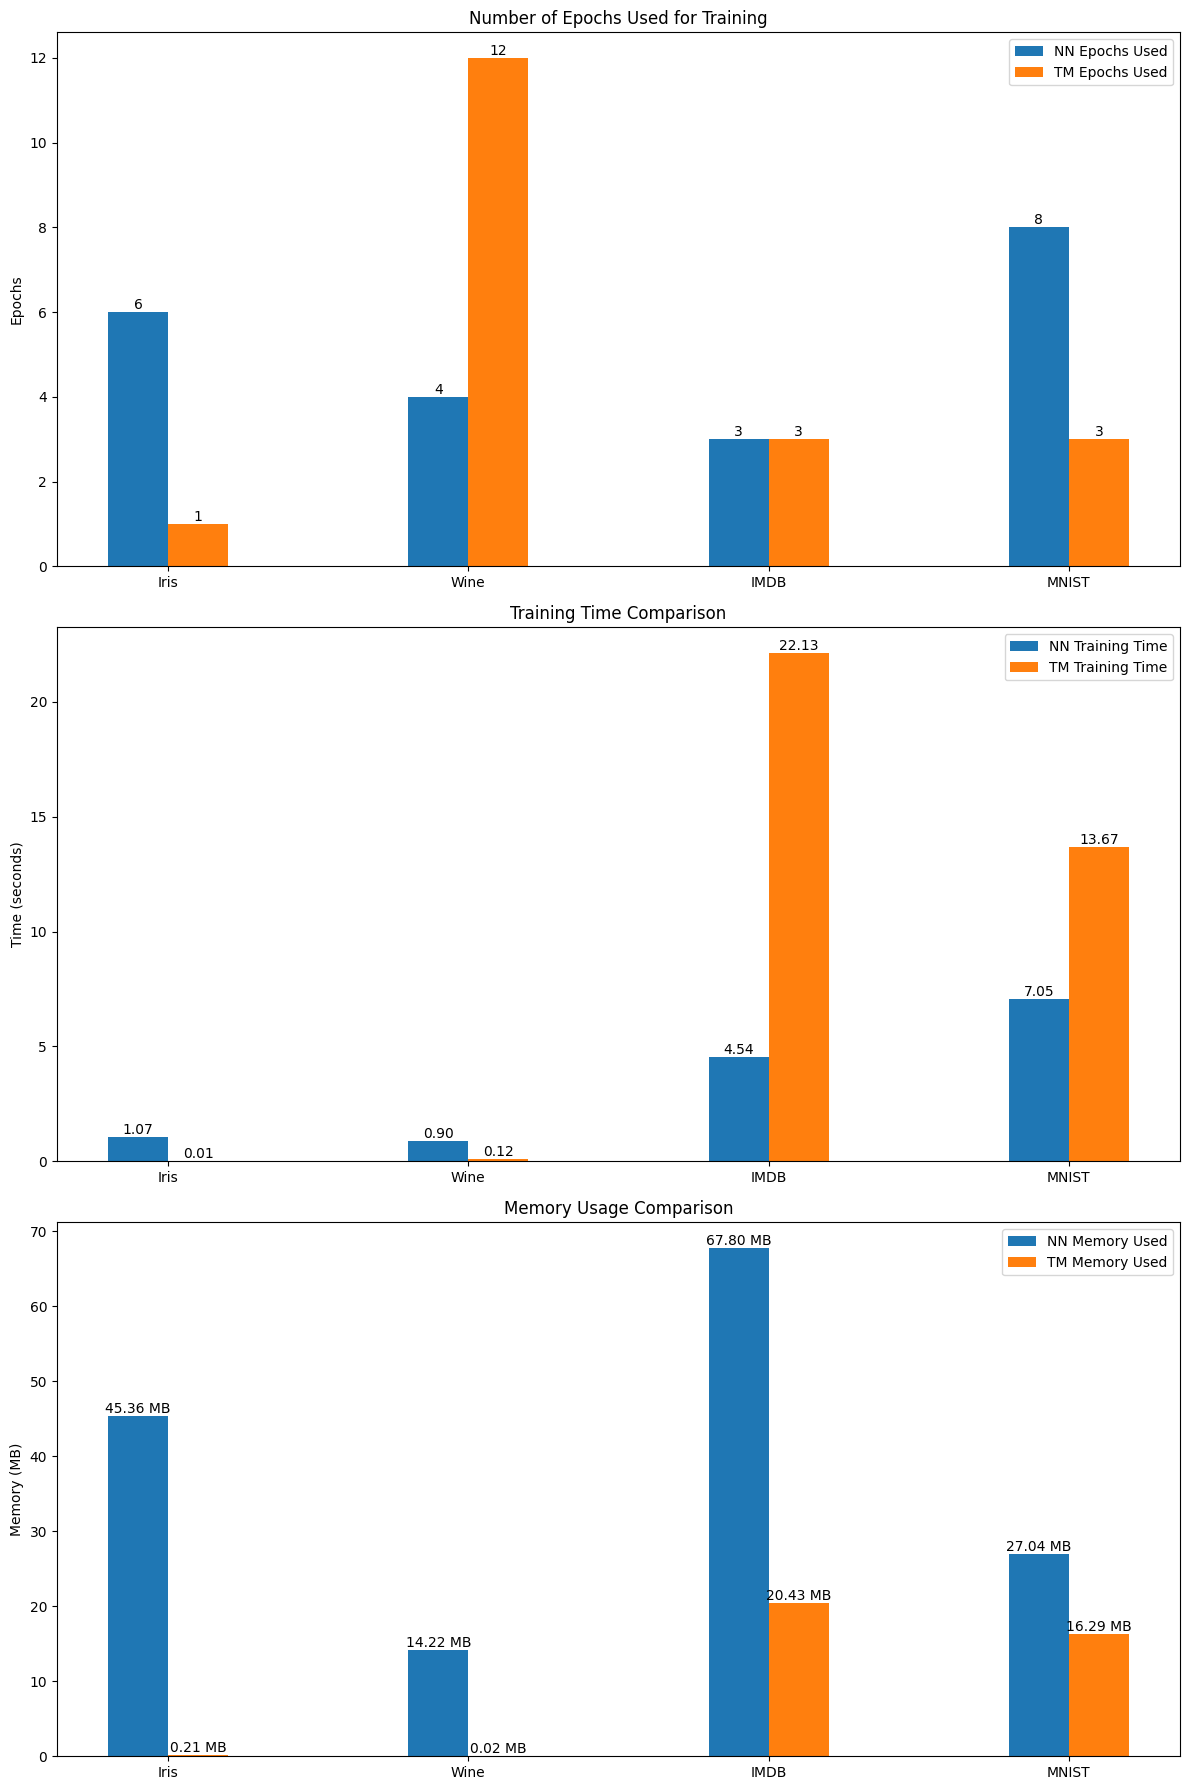

In [26]:
datasets = list(results.keys())
nn_train_time = [results[ds]["Neural Network"][2] for ds in datasets]
nn_memory_used = [results[ds]["Neural Network"][3] for ds in datasets]

tm_train_time = [results[ds]["Tsetlin Machine"][2] for ds in datasets]
tm_memory_used = [results[ds]["Tsetlin Machine"][3] for ds in datasets]

# Calculating number of epochs used for training (total time divided by average epoch time)
nn_epochs = [results[ds]["Neural Network"][4] for ds in datasets]
tm_epochs = [results[ds]["Tsetlin Machine"][4] for ds in datasets]

x = np.arange(len(datasets))
width = 0.2  

fig, ax = plt.subplots(3, 1, figsize=(12, 18))

nn_epochs_bars = ax[0].bar(x - width / 2, nn_epochs, width, label='NN Epochs Used')
tm_epochs_bars = ax[0].bar(x + width / 2, tm_epochs, width, label='TM Epochs Used')

ax[0].set_ylabel('Epochs')
ax[0].set_title('Number of Epochs Used for Training')
ax[0].set_xticks(x)
ax[0].set_xticklabels(datasets)
ax[0].legend()

for bars in [nn_epochs_bars, tm_epochs_bars]:
    for bar in bars:
        height = bar.get_height()
        ax[0].text(bar.get_x() + bar.get_width() / 2., height, f'{height}', ha='center', va='bottom')

nn_train_time_bars = ax[1].bar(x - width / 2, nn_train_time, width, label='NN Training Time')
tm_train_time_bars = ax[1].bar(x + width / 2, tm_train_time, width, label='TM Training Time')
ax[1].set_ylabel('Time (seconds)')
ax[1].set_title('Training Time Comparison')
ax[1].set_xticks(x)
ax[1].set_xticklabels(datasets)
ax[1].legend()

for bars in [nn_train_time_bars, tm_train_time_bars]:
    for bar in bars:
        height = bar.get_height()
        ax[1].text(bar.get_x() + bar.get_width() / 2., height, f'{height:.2f}', ha='center', va='bottom')

nn_memory_bars = ax[2].bar(x - width / 2, nn_memory_used, width, label='NN Memory Used')
tm_memory_bars = ax[2].bar(x + width / 2, tm_memory_used, width, label='TM Memory Used')
ax[2].set_ylabel('Memory (MB)')
ax[2].set_title('Memory Usage Comparison')
ax[2].set_xticks(x)
ax[2].set_xticklabels(datasets)
ax[2].legend()

for bars in [nn_memory_bars, tm_memory_bars]:
    for bar in bars:
        height = bar.get_height()
        ax[2].text(bar.get_x() + bar.get_width() / 2., height, f'{height:.2f} MB', ha='center', va='bottom')

fig.tight_layout()
plt.show()

In [24]:
import pandas as pd
from IPython.display import display

datasets = {
        "Iris": (preprocess_iris(), 90),
        "Wine": (preprocess_wine(), 80),
        "IMDB": (preprocess_imdb(), 87),
        "MNIST": (preprocess_mnist(), 95)
    }

flattened_results = []

for dataset, models in results.items():
    data, target_accuracy = datasets[dataset]  
    for model_name, metrics in models.items():
        flattened_results.append({
            "Dataset": dataset,
            "Model": model_name,
            "Target Accuracy (%)": target_accuracy,
            "Training Time (s)": metrics[2],
            "Memory Used (MB)": metrics[3],
            "Epochs Used": metrics[4]
        })

results_df = pd.DataFrame(flattened_results)

display(results_df)


,Dataset,Model,Target Accuracy (%),Training Time (s),Memory Used (MB),Epochs Used
0,Iris,Neural Network,90,1.068348,45.355469,6
1,Iris,Tsetlin Machine,90,0.008430,0.210938,1
2,Wine,Neural Network,80,0.897581,14.218750,4
3,Wine,Tsetlin Machine,80,0.115490,0.023438,12
4,IMDB,Neural Network,87,4.540351,67.800781,3
5,IMDB,Tsetlin Machine,87,22.134461,20.425781,3
6,MNIST,Neural Network,95,7.046090,27.035156,8
7,MNIST,Tsetlin Machine,95,13.667397,16.292969,3
